In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path  
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import gzip
import os
import sys
import glob
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from urllib.request import urlopen
from urllib.parse import quote
from rdkit.Chem import Descriptors

# Train data
## Corelations between steps and syba, sa, sc

### Denis data

In [2]:
df1 = pd.read_csv('data/Denis_final_data_after_pipeline.csv')
df1 = df1[df1.steps > 0]
df1 = df1.drop_duplicates(subset=['smiles'])
df1 = df1.drop(columns=['orig_smiles','orig_index','is_solved','pipeline_status','syba_score'])

In [3]:
df1.head()

,smiles,steps,syba,sa,sc
0,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,1,23.635963,2.979265,2.881520
1,CC(=O)C(=O)O,1,2.978129,1.841613,1.361031
2,C[N+](C)(C)CCO,1,20.562749,3.003778,1.000185
3,NCCCNCCCCNCCCN,1,-14.811037,2.178531,2.000314
4,O=C(O)CCC(=O)O,1,5.412548,1.608031,1.517970


In [4]:
df1.steps.value_counts()

1     2088
2     1396
13    1142
12    1043
11     637
3      636
4      483
10     448
5      426
9      372
6      366
8      356
7      352
Name: steps, dtype: int64

### Reaxys reactions and numSteps

In [5]:
path = 'data/reaxys_reactions_and_numSteps'
files = Path(path).glob('*.csv') 

In [6]:
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

In [7]:
ids = []
for index, row in df.iterrows():
    if row.NumSteps not in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14']:
        ids.append(index)
print(len(ids))
df = df.drop(ids)
df = df.drop(columns=['Unnamed: 5','Unnamed: 6','Reaction ID','Reaction','Reactant'])

816


In [8]:
len(df)

59184

In [9]:
df = df.drop_duplicates()

In [10]:
len(df)

35322

<AxesSubplot:xlabel='NumSteps', ylabel='Count'>

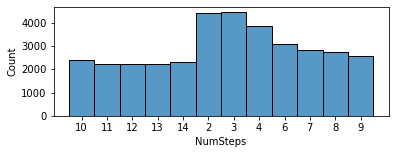

In [11]:
plt.figure(figsize=(6,2))
sns.histplot(df.NumSteps)

In [12]:
df.NumSteps.value_counts()

3     4445
2     4407
4     3869
6     3088
7     2842
8     2724
9     2572
10    2381
14    2317
13    2242
11    2229
12    2206
Name: NumSteps, dtype: int64

In [13]:
s = [('11',2000),('12',2000),('3',2000),('4',2000),('10',2200),('9',2400),('6',2400),('8',2400),('7',2400)]
dfs =[]
for i in s:
    df_cut = df[df.NumSteps == i[0]]
    sample = df_cut.sample(n=i[1])
    dfs.append(sample)
df_train = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

In [15]:
identifiers  = df_train.Product
s = []
for ids in identifiers :
    s.append(CIRconvert(ids))

In [16]:
df_train_all = df_train.assign(smiles=s)
df_train_all.head()

,Product,NumSteps,smiles
0,"(12R,13R,15R)-15-[5-(3-Chloro-1-triisopropylsi...",11,COc1cc(oc1[C@@]2(O)[C@@H]3CCCCCCCCc4cc([C@@H]3...
1,"(7E,9E,13E)-(5S,6S,15S)-5,6,15-Trihydroxy-icos...",11,CCCCC[C@H](O)/C=C/C#C/C=C/C=C/[C@H](O)[C@@H](O...
2,"[(1S,3S,6S,7S,8R)-7-Hydroxy-6-(4-methoxy-benzy...",11,COc1ccc(C[C@H]2[C@@H](O)[C@H]3C[C@@]4(CCC3=O)C...
3,"(2S,3S)-2-[((S)-2-Azido-2-methyl-3-triethylsil...",11,CC[Si](CC)(CC)OC[C@](C)(N=[N+]=[N-])C(=O)N(C)[...
4,16-oxahimgaline,11,Did not work


In [17]:
df_train = df_train_all[df_train_all.smiles != 'Did not work']
len(df_train_all), len(df_train)

(19800, 11792)

In [44]:
# Did not work structures
df_broken = df_train_all[df_train_all.smiles == 'Did not work']
df_broken.head(10)

,Product,NumSteps,smiles
4,16-oxahimgaline,11,Did not work
5,C37H55ClO7Si,11,Did not work
8,C44H72O10S2Si,11,Did not work
11,19.20-dehydrotubifoline,11,Did not work
12,"(2S,5R)-5-{(8'R)-8'-tert-Butyldimethylsilyloxy...",11,Did not work
18,C42H58O7Si,11,Did not work
19,"5,7,8,9,10,11,11a,12-octahydro-5-(hydroxymethy...",11,Did not work
22,(6R)-[(5S)-(2-hydroxyethyl)-(4S)-isopropyl-(5S...,11,Did not work
25,"(1'S)-2-benzyloxy-4-methyl-6-(1',2',2'-trimeth...",11,Did not work
30,"(2R,3S,4R,5S,6S,9R,10R,11S,12S,13R)-9,11-(S)-(...",11,Did not work


In [45]:
filepath = Path('data/7Mdf_broken.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_broken.to_csv(filepath, index=True) 

In [19]:
df_train = df_train.drop(columns=['Product'])
df_train.rename(columns = {'NumSteps':'steps'}, inplace = True)

In [20]:
df_train.steps.value_counts()

3     1584
6     1410
8     1383
7     1378
4     1355
9     1345
10    1213
11    1084
12    1040
Name: steps, dtype: int64

In [21]:
filepath = Path('data/7Mdf_train_temp.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath, index=False) 

In [22]:
df_train = pd.read_csv('data/7Mdf_train_temp.csv')
df_train.head()

,steps,smiles
0,11,COc1cc(oc1[C@@]2(O)[C@@H]3CCCCCCCCc4cc([C@@H]3...
1,11,CCCCC[C@H](O)/C=C/C#C/C=C/C=C/[C@H](O)[C@@H](O...
2,11,COc1ccc(C[C@H]2[C@@H](O)[C@H]3C[C@@]4(CCC3=O)C...
3,11,CC[Si](CC)(CC)OC[C@](C)(N=[N+]=[N-])C(=O)N(C)[...
4,11,CN(C)C(=O)C[C@@H](Cc1ccc(O[P](=O)(OCc2ccccc2)O...


In [23]:
sc = SCScorer()
sy = SybaClassifier()
sy.fitDefaultScore()

In [24]:
sc.restore(os.path.join(r'C:\Users\domiz\Documents\Python\DP\scscore',
                             'models', 
                             'full_reaxys_model_1024bool', 
                             'model.ckpt-10654.as_numpy.json.gz'))

Restored variables from C:\Users\domiz\Documents\Python\DP\scscore\models\full_reaxys_model_1024bool\model.ckpt-10654.as_numpy.json.gz


In [26]:
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df_train.smiles]
scscore = [sc.get_score_from_smi(smile)[1] for smile in df_train.smiles]
syba = [sy.predict(smile) for smile in df_train.smiles]
df_train = df_train.assign(syba=syba)
df_train = df_train.assign(sc=scscore)
df_train = df_train.assign(sa=sascore)

In [27]:
dfs =[]
dfs.append(df1)
dfs.append(df_train)
df = pd.concat(dfs, axis=0, ignore_index=True)

In [32]:
df.steps.value_counts(), df1.steps.value_counts()

(3     2220
 1     2088
 12    2083
 4     1838
 6     1776
 8     1739
 7     1730
 11    1721
 9     1717
 10    1661
 2     1396
 13    1142
 5      426
 Name: steps, dtype: int64,
 1     2088
 2     1396
 13    1142
 12    1043
 11     637
 3      636
 4      483
 10     448
 5      426
 9      372
 6      366
 8      356
 7      352
 Name: steps, dtype: int64)

In [33]:
df.head()

,smiles,steps,syba,sa,sc
0,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,1,23.635963,2.979265,2.881520
1,CC(=O)C(=O)O,1,2.978129,1.841613,1.361031
2,C[N+](C)(C)CCO,1,20.562749,3.003778,1.000185
3,NCCCNCCCCNCCCN,1,-14.811037,2.178531,2.000314
4,O=C(O)CCC(=O)O,1,5.412548,1.608031,1.517970


## Descriptors

In [34]:
mols = [Chem.MolFromSmiles(m) for m in df.smiles]
df = df.assign(mol=mols)

In [35]:
#dir(Descriptors)

In [36]:
df['MolWt'] = df.mol.apply(Descriptors.MolWt)
df['MolLogP'] = df.mol.apply(Descriptors.MolLogP)
df['NumHAccept'] = df.mol.apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df.mol.apply(Descriptors.NumHDonors)
df['NumHetero'] = df.mol.apply(Descriptors.NumHeteroatoms)
df['TPSA'] = df.mol.apply(Descriptors.TPSA)

In [37]:
df.head()

,smiles,steps,syba,sa,sc,mol,MolWt,MolLogP,NumHAccept,NumHDonors,NumHetero,TPSA
0,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,1,23.635963,2.979265,2.881520,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,247.143,0.51742,5,3,8,116.95
1,CC(=O)C(=O)O,1,2.978129,1.841613,1.361031,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,88.062,-0.34000,2,1,3,54.37
2,C[N+](C)(C)CCO,1,20.562749,3.003778,1.000185,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,104.173,-0.31510,1,1,2,20.23
3,NCCCNCCCCNCCCN,1,-14.811037,2.178531,2.000314,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,202.346,-0.35660,4,4,4,76.10
4,O=C(O)CCC(=O)O,1,5.412548,1.608031,1.517970,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,118.088,-0.06420,2,2,4,74.60


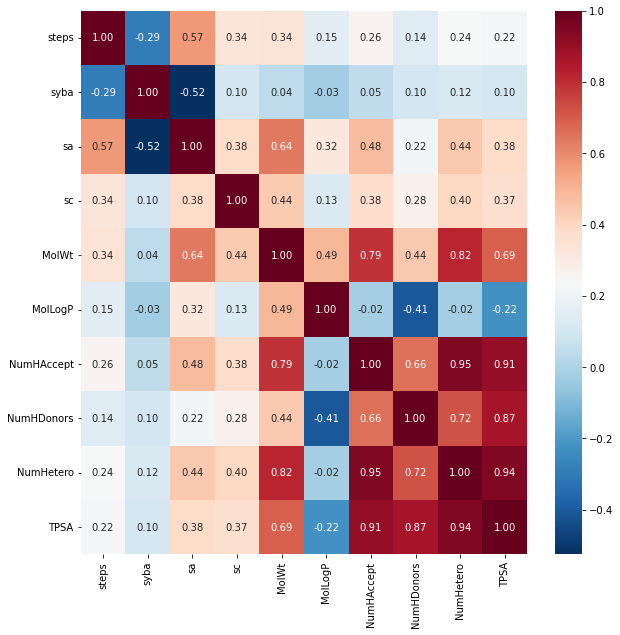

In [38]:
plt.figure(figsize=(10,10))
g = sns.heatmap(df[['steps', 'syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept',
                    'NumHDonors','NumHetero','TPSA']].corr(), 
                annot=True, fmt = ".2f", cmap = "RdBu_r")


In [39]:
#df.groupby(['steps'], as_index=False).mean()
df[['steps', 'syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA']].groupby(['steps'],
                                                                                                        as_index=False).mean()

,steps,syba,sa,sc,MolWt,MolLogP,NumHAccept,NumHDonors,NumHetero,TPSA
0,1,47.212659,2.327086,2.529866,237.608023,1.854614,3.196360,1.621648,4.613506,61.115977
1,2,69.054617,2.636607,3.422138,343.858519,2.969650,4.437679,1.813754,6.379656,75.207299
2,3,36.222864,2.666165,2.617525,280.495435,2.559924,3.471171,1.307658,4.875676,59.641572
3,4,30.984713,3.313595,2.980267,369.801032,3.458190,4.441785,1.507073,6.034820,73.304423
4,5,43.030291,3.437245,3.796920,421.812923,3.013290,5.607981,2.314554,8.124413,97.281901
5,6,20.619525,3.996962,3.260606,466.617168,4.376418,5.637950,1.645833,7.443694,87.569673
6,7,17.709330,4.186427,3.369279,500.744944,4.761677,5.977457,1.730636,7.915029,92.282954
7,8,14.041846,4.292836,3.381477,509.026954,4.864928,6.084531,1.679126,8.034503,93.060075
8,9,11.352767,4.438633,3.465848,534.062949,5.019949,6.423995,1.820617,8.534071,98.343722
9,10,11.694494,4.503285,3.521063,543.184152,4.997793,6.462372,1.960265,8.682721,102.071589


[Text(0.5, 0, 'steps'), Text(0, 0.5, 'TPSA')]

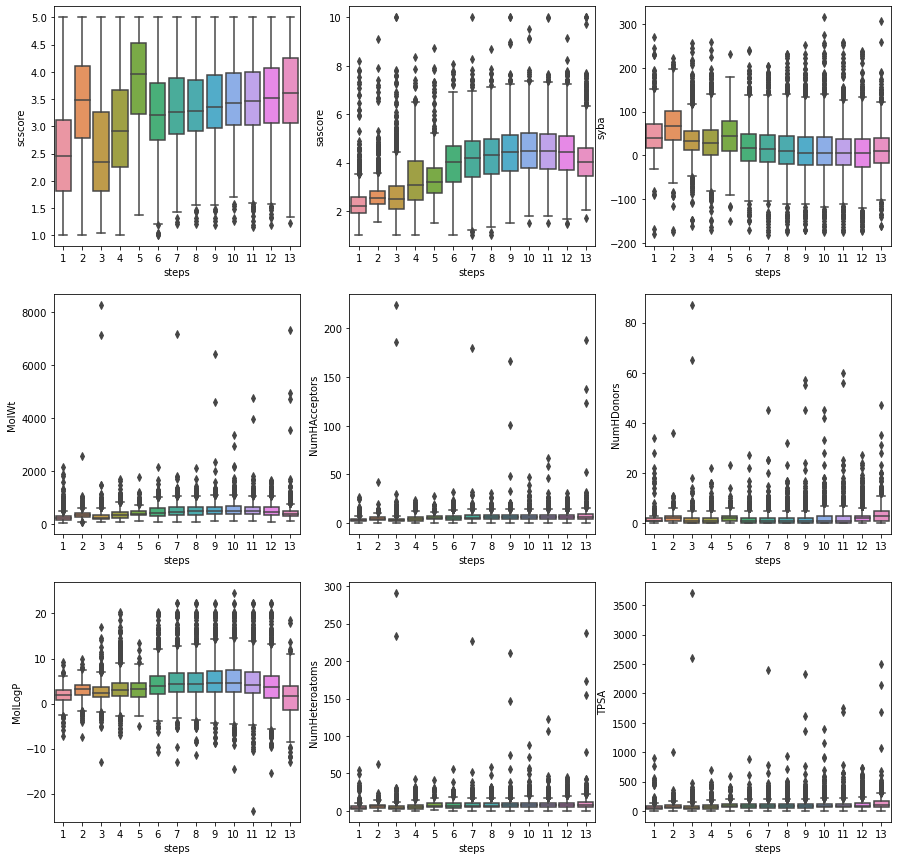

In [40]:
fig, axs = plt.subplots(ncols=3,nrows = 3,figsize=(15,15))
plt.subplots_adjust(wspace = 0.2)

sns.boxplot(x='steps', y='sc', data=df, ax=axs[0,0])
sns.boxplot(x='steps', y='sa', data=df, ax=axs[0,1])
sns.boxplot(x='steps', y='syba', data=df, ax=axs[0,2])
sns.boxplot(x='steps', y='MolWt', data=df, ax=axs[1,0])
sns.boxplot(x='steps', y='NumHAccept', data=df, ax=axs[1,1])
sns.boxplot(x='steps', y='NumHDonors', data=df, ax=axs[1,2])
sns.boxplot(x='steps', y='MolLogP', data=df, ax=axs[2,0])
sns.boxplot(x='steps', y='NumHetero', data=df, ax=axs[2,1])
sns.boxplot(x='steps', y='TPSA', data=df, ax=axs[2,2])

axs[0,0].set(xlabel="steps", ylabel = "scscore")
axs[0,1].set(xlabel="steps", ylabel = "sascore")
axs[0,2].set(xlabel="steps", ylabel = "syba")
axs[1,0].set(xlabel="steps", ylabel = "MolWt")
axs[1,1].set(xlabel="steps", ylabel = "NumHAcceptors")
axs[1,2].set(xlabel="steps", ylabel = "NumHDonors")
axs[2,0].set(xlabel="steps", ylabel = "MolLogP")
axs[2,1].set(xlabel="steps", ylabel = "NumHeteroatoms")
axs[2,2].set(xlabel="steps", ylabel = "TPSA")

[Text(0.5, 0, 'steps'), Text(0, 0.5, 'TPSA')]

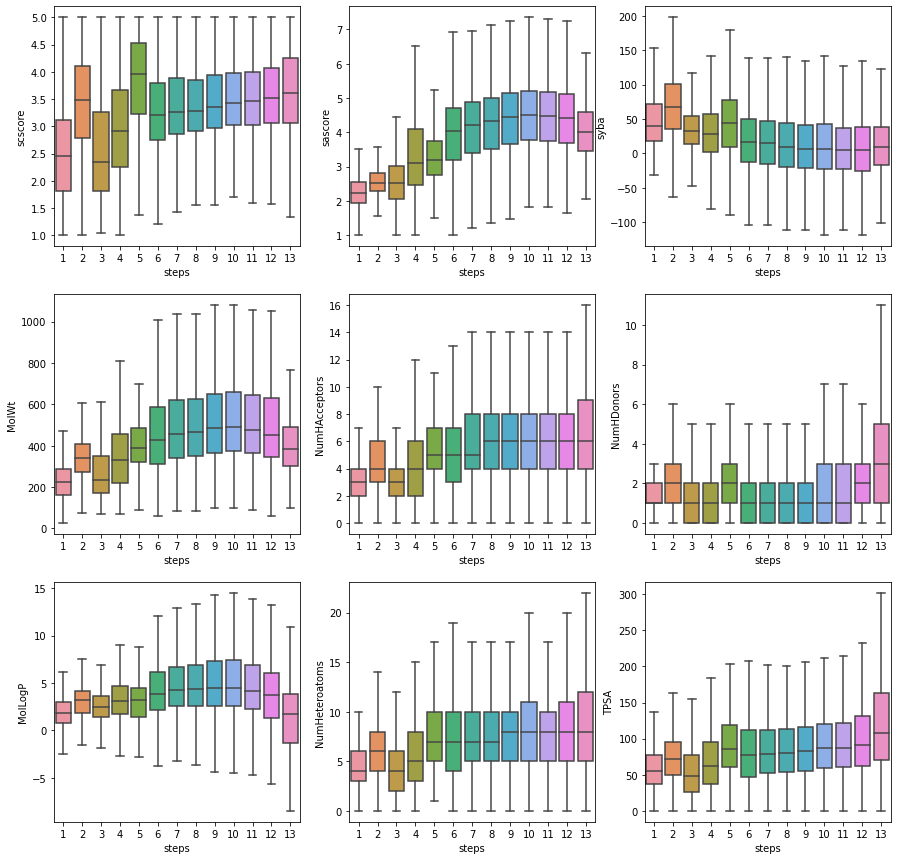

In [41]:
fig, axs = plt.subplots(ncols=3,nrows = 3,figsize=(15,15))
plt.subplots_adjust(wspace = 0.2)

sns.boxplot(x='steps', y='sc', data=df, ax=axs[0,0],showfliers=False)
sns.boxplot(x='steps', y='sa', data=df, ax=axs[0,1],showfliers=False)
sns.boxplot(x='steps', y='syba', data=df, ax=axs[0,2],showfliers=False)
sns.boxplot(x='steps', y='MolWt', data=df, ax=axs[1,0],showfliers=False)
sns.boxplot(x='steps', y='NumHAccept', data=df, ax=axs[1,1],showfliers=False)
sns.boxplot(x='steps', y='NumHDonors', data=df, ax=axs[1,2],showfliers=False)
sns.boxplot(x='steps', y='MolLogP', data=df, ax=axs[2,0],showfliers=False)
sns.boxplot(x='steps', y='NumHetero', data=df, ax=axs[2,1],showfliers=False)
sns.boxplot(x='steps', y='TPSA', data=df, ax=axs[2,2],showfliers=False)

axs[0,0].set(xlabel="steps", ylabel = "scscore")
axs[0,1].set(xlabel="steps", ylabel = "sascore")
axs[0,2].set(xlabel="steps", ylabel = "syba")
axs[1,0].set(xlabel="steps", ylabel = "MolWt")
axs[1,1].set(xlabel="steps", ylabel = "NumHAcceptors")
axs[1,2].set(xlabel="steps", ylabel = "NumHDonors")
axs[2,0].set(xlabel="steps", ylabel = "MolLogP")
axs[2,1].set(xlabel="steps", ylabel = "NumHeteroatoms")
axs[2,2].set(xlabel="steps", ylabel = "TPSA")

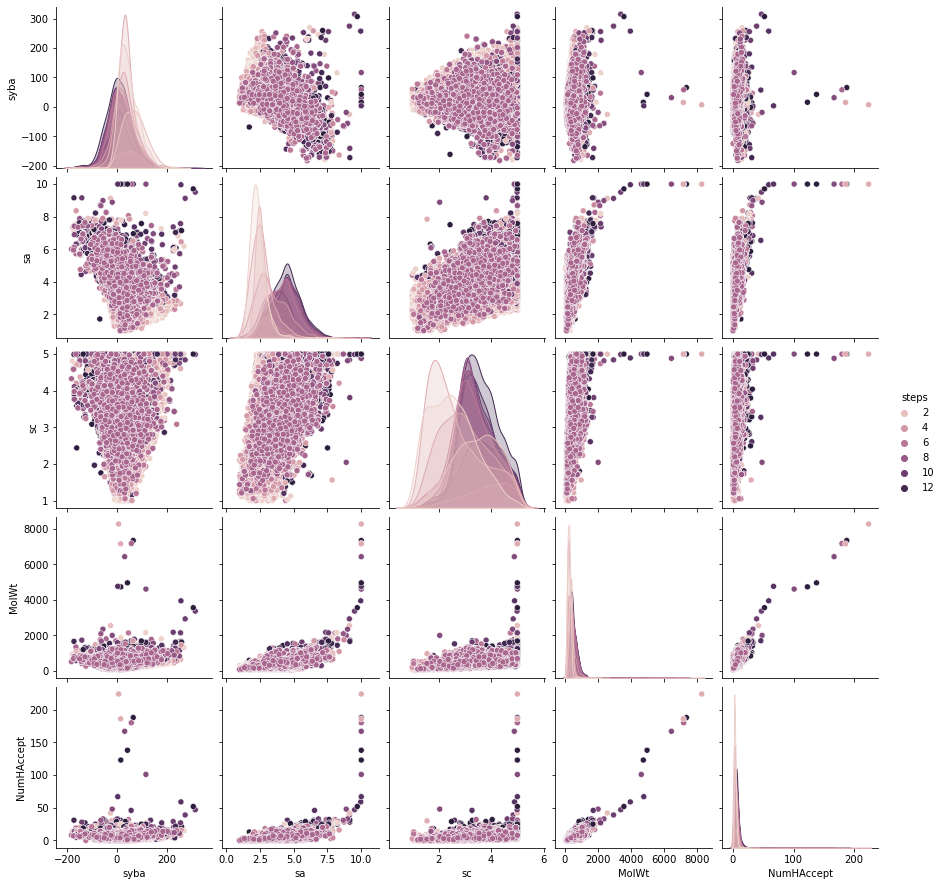

In [42]:
sns.pairplot(df[['steps','syba', 'sa', 'sc','MolWt','NumHAccept']], hue='steps')

In [43]:
filepath = Path('data/7Mtrain_descriptors.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False) 